In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cleaning import text_prepare # self-created library

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
import re, string
from nltk import word_tokenize, sent_tokenize
from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, Activation, LSTM, concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Reshape, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import regularizers

In [3]:
# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
emb = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [4]:
data_train = pd.read_csv("trainData.csv")
data_train.tail(5)

,uniqueID,drugName,condition,review,rating,date,usefulCount,processed_text
73946,18421,Zolpidem,Insomnia,"""I started taking this medication 10 years ago...",10,16-Nov-08,103,start take medication ten years ago doctor tel...
73947,228492,Geodon,Bipolar Disorde,"""I was in a very bad place at the time I start...",3,25-Jul-16,5,bad place time start take doctor want ween eff...
73948,93069,Vortioxetine,Depression,"""This is the third med I&#039;ve tried for anx...",2,17-Jul-16,33,third med 've try anxiety mild depression week...
73949,132177,Ativan,Anxiety,"""I was super against taking medication. I&#039...",9,16-Aug-16,61,super take medication 've start deal anxiety d...
73950,164345,Junel 1.5 / 30,Birth Control,"""This would be my second month on Junel. I&#03...",6,27-May-15,0,would second month junel 've birth control ten...


In [5]:
X = data_train.processed_text.values
y = data_train.condition.values

In [6]:
# One-hot encoding the classes (alphabetically by default)
le = LabelBinarizer()
y = le.fit_transform(y)
le.classes_

array(['ADHD', 'Acne', 'Anxiety', 'Bipolar Disorde', 'Birth Control',
       'Depression', 'Insomnia', 'Obesity', 'Pain', 'Weight Loss'],
      dtype='<U15')

In [7]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Basic Logistic Regression

In [44]:
# Splitting data into train:test by 80:20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)

In [45]:
# Creating the vectorizer
tfidf = TfidfVectorizer(max_features = 10000, ngram_range=(1,3), min_df=5, max_df=0.9)
tfidf = tfidf.fit(X_train)

In [46]:
X_train = tfidf.transform(X_train).toarray()
print('\nTraining features shape: ',X_train.shape)

X_val = tfidf.transform(X_val).toarray()
print('Test features shape:     ',X_val.shape)


Training features shape:  (59160, 10000)
Test features shape:      (14791, 10000)


In [48]:
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
clf = clf.fit(X_train, y_train)
prediction = clf.predict(X_val)

In [49]:
print("\nClassifier results: \n")
print(classification_report(prediction, y_val, target_names = list(le.classes_)))


Classifier results: 



C:\Users\welcome\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

           ADHD       0.71      0.99      0.82       488
           Acne       0.81      0.95      0.87       968
        Anxiety       0.59      0.86      0.70       772
Bipolar Disorde       0.57      0.92      0.70       507
  Birth Control       0.97      0.97      0.97      5720
     Depression       0.63      0.86      0.73      1315
       Insomnia       0.71      0.91      0.80       541
        Obesity       0.41      0.66      0.51       463
           Pain       0.80      0.97      0.88      1058
    Weight Loss       0.47      0.69      0.56       508

      micro avg       0.77      0.92      0.84     12340
      macro avg       0.67      0.88      0.75     12340
   weighted avg       0.80      0.92      0.85     12340
    samples avg       0.77      0.76      0.76     12340



### CNN-LSTM

In [8]:
# Splitting data into train:test by 80:20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)

In [9]:
NUM_WORDS=24000
tokenizer = Tokenizer(num_words=NUM_WORDS)

# Converting text to tokens
tokenizer.fit_on_texts(X_train)

# Converting into sequential data
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_valid = tokenizer.texts_to_sequences(X_val)

# 
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 24195 unique tokens.


In [10]:
X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid,maxlen=X_train.shape[1])

print('Shape of X train and X validation tensor:', X_train.shape,X_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)

Shape of X train and X validation tensor: (59160, 440) (14791, 440)
Shape of label train and validation tensor: (59160, 10) (14791, 10)


In [11]:
SEQUENCE_LEN = X_train.shape[1]
EMBEDDING_DIM = 300

In [12]:
vocabulary_size = min(len(word_index)+1, NUM_WORDS)

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= NUM_WORDS:
        continue
    try:
        embedding_vector = emb[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

In [13]:
embedding_matrix.shape

(24000, 300)

In [14]:
SEQUENCE_LEN

440

In [16]:
model= Sequential()
model.add(Embedding(NUM_WORDS, EMBEDDING_DIM, weights = [embedding_matrix], input_length = SEQUENCE_LEN))

model.add(Conv1D(32,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.3))

model.add(Conv1D(64,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.3))

model.add(Conv1D(128,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.4))

model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(10,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])    
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 440, 300)          7200000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 440, 32)           28832     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 146, 32)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 146, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 146, 64)           6208      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 48, 64)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 48, 64)           

In [17]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
925/925 [==============================] - ETA: 0s - loss: 1.0928 - accuracy: 0.5941WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000281E74FFAF8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

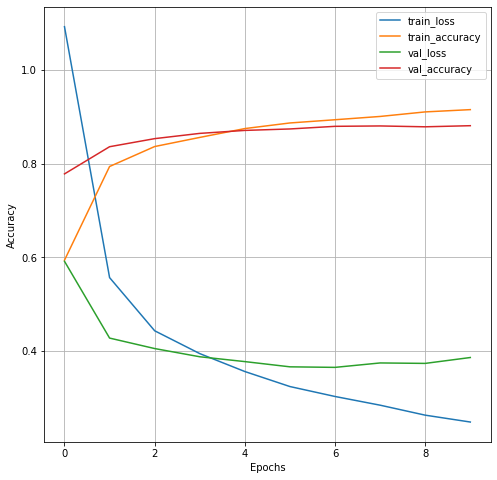

In [30]:
history_df = pd.DataFrame(model.history.history).rename(columns={"loss":"train_loss", "accuracy":"train_accuracy"})
history_df.plot(figsize=(8,8))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [32]:
model.save('model_cnn3_lstm1.h5') 

In [33]:
data_test = pd.read_csv("testData.csv")
data_test.tail(5)

,uniqueID,drugName,condition,review,rating,date,usefulCount,processed_text
24767,33495,Microgestin Fe 1 / 20,Birth Control,"""I was on Microgestin for about 3 years. Over ...",6,1-Aug-14,15,microgestin three years past year start get ex...
24768,123432,Apri,Birth Control,"""I started taking Apri about 7 months ago. My ...",9,25-Aug-10,18,start take apri seven months ago breats get no...
24769,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11,'ve take lexapro escitaploprgram since februar...
24770,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7,'m marry thirty-four years old kid take pill h...
24771,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20,prescribe nucynta severe neck/shoulder pain ta...


In [38]:
X_test = data_test.processed_text.values
y_test = data_test.condition.values

# One-hot encoding the classes (alphabetically by default)
y_test = le.transform(y_test)

In [39]:
sequences_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(sequences_test, maxlen=SEQUENCE_LEN)
X_test.shape

(24772, 440)

In [40]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss : ',test_loss,' Test Accuracy : ',test_acc)

775/775 [==============================] - 13s 17ms/step - loss: 0.4075 - accuracy: 0.8788
Test Loss :  0.40751996636390686  Test Accuracy :  0.8788148164749146


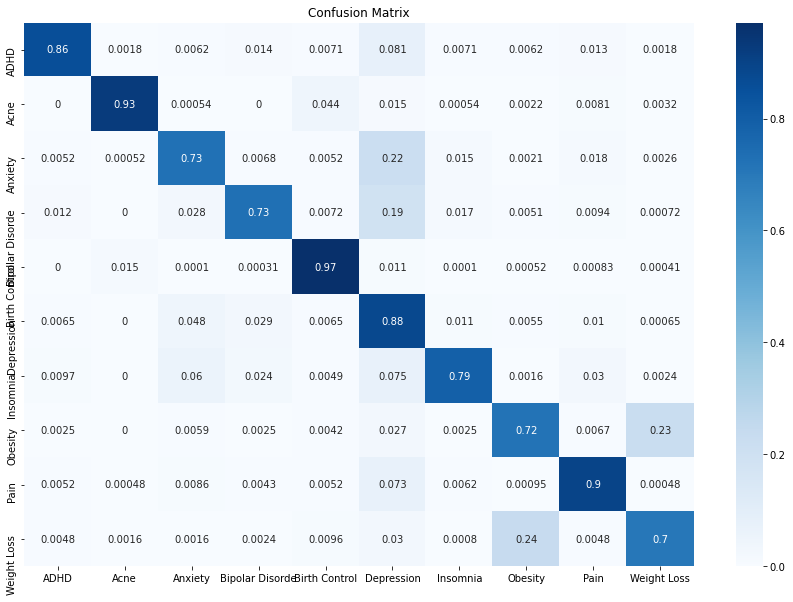

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test.argmax(axis=1), predictions, normalize='true')

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, cmap='Blues', annot=True, ax = ax); 

# Labels, title and ticks
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(le.classes_)); 
ax.yaxis.set_ticklabels(list(le.classes_));